### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [8]:
import numpy as np
import matplotlib.pylab as plt
# plt.style.use('ggplot')
import time

In [9]:
%matplotlib inline

In [99]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat
                C[i] = 0.
                theta[i] = theta_S
    except TypeError:
        if h > 0:
            K = Ksat
            C = 0.
            theta = theta_S
    return [C,K,theta]

In [100]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09

# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [101]:
# set up vertical grid 
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

In [102]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [103]:
# Define ICs boundary conditions at top and bottom
hinit = np.arange(nz)*-5
hinit = -1000*np.ones(nz)
hinit[0] = 0.

htop = hinit[0]
hbottom = hinit[-1]

In [104]:
# Define time variables
stop_tol = 1e-5  # Stopping tolerance [cm]
dt = .01 # [s]

tmin = 0. # [s]
# nt = 1000
tmax = 1
# times = np.arange(tmin, tmax, dt)[:nt]  #(tmin:dt:tmax);

# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = [] # np.zeros([nz,nt])
K =[] # np.zeros([nz,nt])
C = [] # np.zeros([nz,nt])
# H[:,0] = hinit
# K[:,0] = Kinit
# C[:,0] = Cinit
H.append(hinit)
K.append(Kinit)
C.append(Cinit)

THETA = []# np.zeros([nz,nt])
# THETA[:,0] = thetainit
THETA.append(thetainit)
ktop = [] # np.zeros([ nt])
ktop.append(Ktop)
kbot = [] # np.zeros([ nt])
kbot.append(Kbottom)
error = [] # np.zeros([nt])
t = [] # np.zeros([nt])
dt_array = [] # np.zeros([nt])
fluxin = []
fluxout= []
newmass = []

0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 0.009 0.028 0.083 0.138 0.193 0.248 0.303 0.358 0.413 0.468 0.487 0.506 --- 3.90688705444 seconds ---


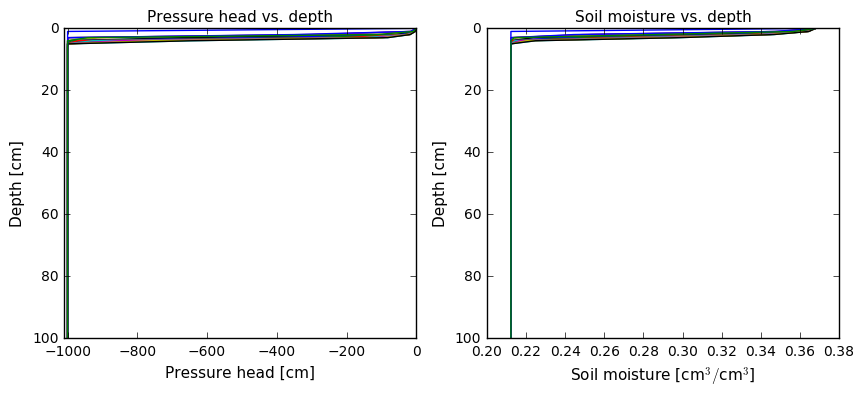

In [110]:
# Figures
fig = plt.figure(1, figsize = (10,4)); 
ax = plt.subplot(121)
plt.plot(hinit,z);
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( -1010, 0)
plt.gca().invert_yaxis()
plt.title('Pressure head vs. depth', fontsize=  11)
ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.gca().invert_yaxis()
plt.title('Soil moisture vs. depth',fontsize=  11)

start_time = time.time()
iterations = [] # np.zeros([nt-1,1]);  # Define array for iteration counter
tc = 0
t.append(tc)
niter = 0
dtc = dt
i = 0
# for i in range(1, nt):   # Initialize the Picard iteration solver
while tc < tmax:
    i += 1
    dtc = dt
    hnp1m =  H[i-1]  
    thetan = THETA[i-1]   
    stop_flag = 0  #Define a dummy stopping variable
    while stop_flag==0:
        if niter > 10:
            hnp1m =  H[i-1]  
            thetan = THETA[i-1]   
            dtc = dtc/10.
#             print dtc,
            niter = 0
            if tc + dtc > tmax:
                dtc = tmax - tc
                print dtc
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi); 
        Cdiag = np.diag(cnp1m) # Compute the individual elements of the A matrix for LHS
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dtc)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
            (1./dz)*(kbarplus - kbarminus) - (1./dtc)*(thetanp1m - thetan) 
        deltam = np.linalg.pinv(A).dot(R_MPFD)    #  Compute deltam for iteration level m+1
        niter = niter + 1      # Increment iteration counter 
        if max(abs(deltam[1:(nz-1)]))<stop_tol:
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam # Force boundary conditions       
            hnp1mp1[0] = htop;
            if BottomBoundCon==0:
                hnp1mp1[nz-1] = hbottom;
            elif (BottomBoundCon==1):
                hnp1mp1[nz-1] = hnp1m[nz-2];
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            thetanp1mp1 = thetanp1m;
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1; 
            tc = tc + dtc
        else:
            hnp1mp1 = hnp1m + deltam;
            hnp1m = hnp1mp1; # Force boundary conditions
            hnp1m[0] = htop;
            if BottomBoundCon==0:
                hnp1m[nz-1] = hbottom;
            elif BottomBoundCon==1:
                hnp1m[nz-1] = hnp1m[nz-2];
    # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
    t.append(tc)
    dt_array.append(dtc)
    THETA.append(thetanp1mp1)
    H.append(hnp1mp1)
    K.append(knp1mp1)
    C.append(cnp1mp1)
    ktop.append((K[i][0] + K[i][1])/2.) 
    kbot.append((K[i][-1] + K[i][-2])/2.)
    error.append(np.sum(A.dot(deltam))*dtc)
    fluxin.append( -ktop[i]*((H[i][1] - H[i][0])/dz + 1.)*dtc )  # top flux (cm)
    fluxout.append(kbot[i]*((H[i][-1] - H[i][-2])/dz + 1. )*dtc) # bottom flux (cm)
    newmass.append((THETA[i] - THETA[i-1]).sum(0) )  #  change in mass 

    
#     error[i] = dz*np.sum(C[1:-1,i]*deltam[1:-1]) -  kbot[i]*(deltam[-1] - deltam[-2])*dt/dz \
#         + ktop[i]*(deltam[1] - deltam[0])*dt/dz
    if (np.mod(i,10)==0):
        print t[i],
        ax = plt.subplot(121)
        plt.plot(H[i],z)
        plt.xlabel('Pressure head [cm]')
        plt.ylabel('Depth [cm]')
        plt.ylim(100, 0)
        ax = plt.subplot(122)
        plt.plot(THETA[i],z)
        plt.xlabel('Soil moisture [cm$^3/$cm$^3$]')
        plt.ylabel('Depth [cm]')
        plt.ylim(100, 0)
    #    save number of iterations
    iterations.append(niter)
print("--- %s seconds ---" % (time.time() - start_time))

In [111]:
dt_array

[0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,

In [107]:
-  ktop*((H[i][1] - H[i][0])/dz + 1.)*dt

TypeError: bad operand type for unary -: 'list'

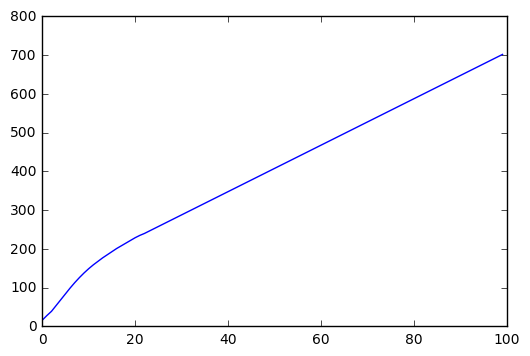

In [108]:
plt.plot(iterations)


(100, 0)

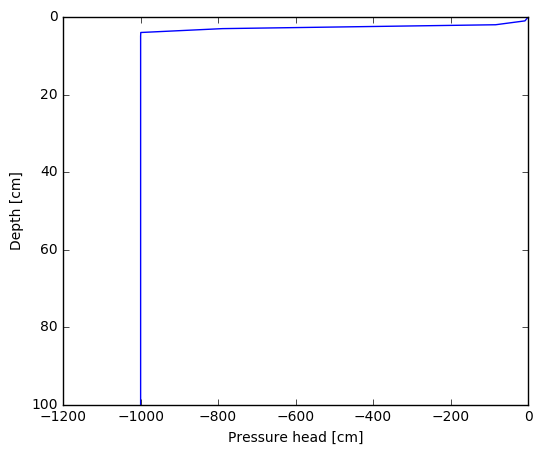

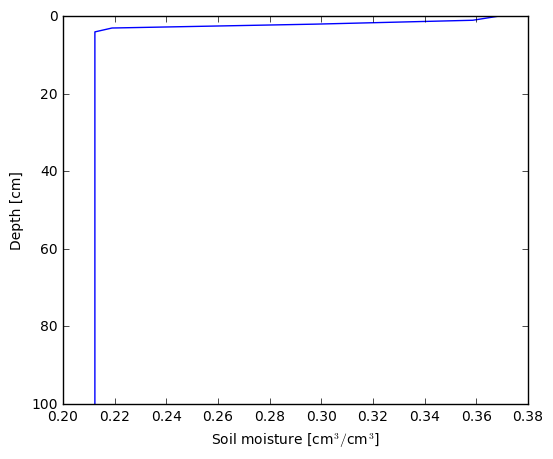

In [43]:
plt.figure(1, figsize= (6,5))
plt.plot(hnp1mp1,z)
plt.xlabel('Pressure head [cm]')
plt.ylabel('Depth [cm]')
plt.ylim(100, 0)
plt.figure(2, figsize= (6,5))
plt.plot(thetanp1mp1,z)
plt.xlabel('Soil moisture [cm$^3/$cm$^3$]')
plt.ylabel('Depth [cm]')
plt.ylim(100, 0)

In [44]:
plt.plot(THETA[: , -1])

TypeError: list indices must be integers, not tuple

In [45]:
# plt.imshow(THETA[:, 1:2000:10])

In [46]:
deltam[1]

9.2575466791028437e-07

In [47]:
fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux

TypeError: bad operand type for unary -: 'list'

In [48]:
H[0]

array([    0., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000.])

In [52]:
fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt # bottom flux
# fluxout =  kbot*((H[-1] - H[-2])/dz )*dt # bottom flux


In [53]:
newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

In [54]:
#  plt.plot(error[1:])
# Hydrus 1D 
# specify depth, 

TypeError: 'float' object has no attribute '__getitem__'

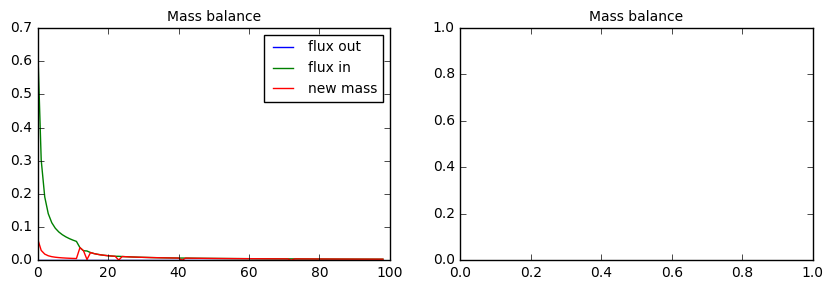

In [55]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:] - error[1:] ,  label = 'time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] ), label =  'cumulative')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:]  ), '--', label =  'unclosed')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass), label =  'cumulative')
plt.legend(fontsize = 10)
# (fluxin[1:] - newmass  + fluxout[1:] +error[1:])

In [56]:
plt.figure(5);
plt.plot(t[1:nt],iterations,'o-');
plt.xlabel('Time [s]');
plt.ylabel('Number of iterations');

TypeError: 'float' object has no attribute '__getitem__'

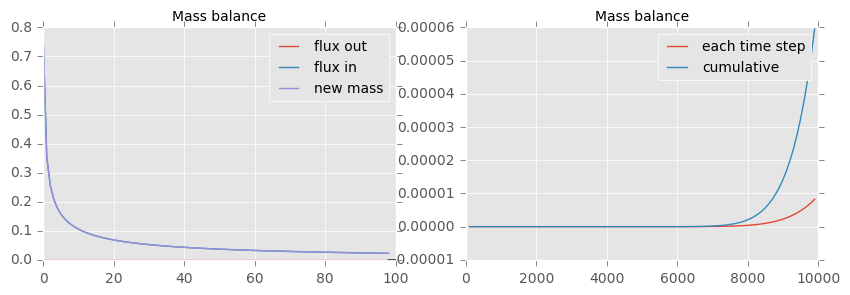

In [18]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:],  label = 'each time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass+ fluxout[1:]), label =  'cumulative')
plt.legend(fontsize = 10)